# GIN Experiment
This notebook will implement the evaluation pipeline with the FID calculation using the GIN

## Setup

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle
from tqdm import tqdm

from util import load_data, load_synth_data, separate_data , load_graph_asS2Vgraph
from models.graphcnn import GraphCNN


criterion = nn.CrossEntropyLoss()

In [2]:
def train(iters_per_epoch, batch_size, model, device, train_graphs, optimizer, epoch):
    model.train()

    total_iters = iters_per_epoch
    pbar = tqdm(range(total_iters), unit='batch')

    loss_accum = 0
    for pos in pbar:
        selected_idx = np.random.permutation(len(train_graphs))[:batch_size]

        batch_graph = [train_graphs[idx] for idx in selected_idx]
        output = model(batch_graph)

        labels = torch.LongTensor([graph.label for graph in batch_graph]).to(device)

        #compute loss
        loss = criterion(output, labels)

        #backprop
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()         
            optimizer.step()
        

        loss = loss.detach().cpu().numpy()
        loss_accum += loss

        #report
        pbar.set_description('epoch: %d' % (epoch))

    average_loss = loss_accum/total_iters
    print("loss training: %f" % (average_loss))
    
    return average_loss

###pass data to model with minibatch during testing to avoid memory overflow (does not perform backpropagation)
def pass_data_iteratively(model, graphs, minibatch_size = 64):
    model.eval()
    output = []
    idx = np.arange(len(graphs))
    for i in range(0, len(graphs), minibatch_size):
        sampled_idx = idx[i:i+minibatch_size]
        if len(sampled_idx) == 0:
            continue
        output.append(model([graphs[j] for j in sampled_idx]).detach())
    return torch.cat(output, 0)

def test(model, device, train_graphs, test_graphs, epoch):
    model.eval()

    output = pass_data_iteratively(model, train_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in train_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc_train = correct / float(len(train_graphs))

    output = pass_data_iteratively(model, test_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in test_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc_test = correct / float(len(test_graphs))

    print("accuracy train: %f test: %f" % (acc_train, acc_test))

    return acc_train, acc_test

## Training settings

In [3]:
dataset = None
device = 0 
batch_size = 32
iters_per_epoch = 50
epochs = 60
lr = 0.01
seed = 0
fold_idx = 1
num_layers = 5
num_mlp_layers = 3
hidden_dim = 64
final_dropout = 0.5
graph_pooling_type = "sum"
neighbor_pooling_type = "sum"
learn_eps = True
degree_as_tag = True
filename = ""
random = 1

## Training 

In [4]:
#set up seeds and gpu device
torch.manual_seed(0)
np.random.seed(0)    
device = torch.device("cuda:" + str(device)) if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

if dataset != None :
    graphs, num_classes = load_data(dataset, degree_as_tag)
else :
    graphs, num_classes, tagset , lentagset = load_synth_data(True, random)
num_classes
##10-fold cross validation. Conduct an experiment on the fold specified by args.fold_idx.
train_graphs, test_graphs = separate_data(graphs, seed, fold_idx)

model = GraphCNN(num_layers, num_mlp_layers, train_graphs[0].node_features.shape[1], hidden_dim, num_classes, final_dropout, learn_eps, graph_pooling_type, neighbor_pooling_type,random, device).to(device)

optimizer = optim.Adam(model.parameters(),lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)


for epoch in range(1, epochs + 1):
    scheduler.step()

    avg_loss = train(iters_per_epoch,batch_size,model, device, train_graphs, optimizer, epoch)
    acc_train, acc_test = test( model, device, train_graphs, test_graphs, epoch)

    if not filename == "":
        with open(filename, 'w') as f:
            f.write("%f %f %f" % (avg_loss, acc_train, acc_test))
            f.write("\n")
    print("")

    print(model.eps)

loading data
# classes: 6
# maximum node tag: 63
# data: 2200


/home/ousmanetouat/anaconda3/envs/graphRL/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
epoch: 1: 100%|██████████| 50/50 [00:02<00:00, 22.59batch/s]


loss training: 32.951359
accuracy train: 0.811616 test: 0.790909

Parameter containing:
tensor([-0.1095, -0.1880,  0.0281, -0.2007], device='cuda:0',
       requires_grad=True)


epoch: 2: 100%|██████████| 50/50 [00:01<00:00, 29.14batch/s]


loss training: 14.535753
accuracy train: 0.890404 test: 0.886364

Parameter containing:
tensor([-0.1592, -0.3036, -0.0396, -0.2493], device='cuda:0',
       requires_grad=True)


epoch: 3: 100%|██████████| 50/50 [00:02<00:00, 24.72batch/s]


loss training: 10.032494
accuracy train: 0.944949 test: 0.940909

Parameter containing:
tensor([-0.2175, -0.3981, -0.0994, -0.3127], device='cuda:0',
       requires_grad=True)


epoch: 4: 100%|██████████| 50/50 [00:01<00:00, 25.80batch/s]


loss training: 9.326299
accuracy train: 0.876768 test: 0.877273

Parameter containing:
tensor([-0.2962, -0.5260, -0.1478, -0.3251], device='cuda:0',
       requires_grad=True)


epoch: 5: 100%|██████████| 50/50 [00:01<00:00, 29.73batch/s]


loss training: 10.301158
accuracy train: 0.710101 test: 0.709091

Parameter containing:
tensor([-0.2225, -0.7369, -0.2049, -0.3720], device='cuda:0',
       requires_grad=True)


epoch: 6: 100%|██████████| 50/50 [00:01<00:00, 29.30batch/s]


loss training: 5.781251
accuracy train: 0.763636 test: 0.768182

Parameter containing:
tensor([-0.2817, -0.7477, -0.2063, -0.3775], device='cuda:0',
       requires_grad=True)


epoch: 7: 100%|██████████| 50/50 [00:01<00:00, 29.37batch/s]


loss training: 5.268178
accuracy train: 0.942929 test: 0.945455

Parameter containing:
tensor([-0.2388, -0.8027, -0.1821, -0.2864], device='cuda:0',
       requires_grad=True)


epoch: 8: 100%|██████████| 50/50 [00:01<00:00, 30.33batch/s]


loss training: 7.189422
accuracy train: 0.903535 test: 0.904545

Parameter containing:
tensor([-0.2138, -0.9019, -0.1740, -0.2978], device='cuda:0',
       requires_grad=True)


epoch: 9: 100%|██████████| 50/50 [00:01<00:00, 30.11batch/s]


loss training: 6.977389
accuracy train: 0.761111 test: 0.768182

Parameter containing:
tensor([-0.3041, -0.9384, -0.1705, -0.2724], device='cuda:0',
       requires_grad=True)


epoch: 10: 100%|██████████| 50/50 [00:01<00:00, 29.83batch/s]


loss training: 7.657804
accuracy train: 0.946970 test: 0.940909

Parameter containing:
tensor([-0.2731, -1.0180, -0.1024, -0.2740], device='cuda:0',
       requires_grad=True)


epoch: 11: 100%|██████████| 50/50 [00:01<00:00, 28.51batch/s]


loss training: 3.113824
accuracy train: 0.754545 test: 0.750000

Parameter containing:
tensor([-0.2725, -0.9794, -0.1398, -0.2799], device='cuda:0',
       requires_grad=True)


epoch: 12: 100%|██████████| 50/50 [00:01<00:00, 29.57batch/s]


loss training: 3.504567
accuracy train: 0.769697 test: 0.763636

Parameter containing:
tensor([-0.2674, -0.9917, -0.1647, -0.2799], device='cuda:0',
       requires_grad=True)


epoch: 13: 100%|██████████| 50/50 [00:01<00:00, 25.90batch/s]


loss training: 1.855248
accuracy train: 0.954040 test: 0.950000

Parameter containing:
tensor([-0.2677, -0.9766, -0.1635, -0.2767], device='cuda:0',
       requires_grad=True)


epoch: 14: 100%|██████████| 50/50 [00:02<00:00, 24.04batch/s]


loss training: 1.095302
accuracy train: 0.986364 test: 0.981818

Parameter containing:
tensor([-0.2507, -0.9620, -0.1540, -0.2788], device='cuda:0',
       requires_grad=True)


epoch: 15: 100%|██████████| 50/50 [00:02<00:00, 23.15batch/s]


loss training: 1.312591
accuracy train: 0.954040 test: 0.954545

Parameter containing:
tensor([-0.2481, -0.9539, -0.1926, -0.2764], device='cuda:0',
       requires_grad=True)


epoch: 16: 100%|██████████| 50/50 [00:01<00:00, 28.92batch/s]


loss training: 2.405580
accuracy train: 1.000000 test: 0.995455

Parameter containing:
tensor([-0.2120, -0.9704, -0.2355, -0.2727], device='cuda:0',
       requires_grad=True)


epoch: 17: 100%|██████████| 50/50 [00:01<00:00, 29.11batch/s]


loss training: 0.681191
accuracy train: 0.987374 test: 0.990909

Parameter containing:
tensor([-0.2081, -0.9857, -0.2238, -0.2688], device='cuda:0',
       requires_grad=True)


epoch: 18: 100%|██████████| 50/50 [00:01<00:00, 27.00batch/s]


loss training: 0.764968
accuracy train: 0.984848 test: 0.981818

Parameter containing:
tensor([-0.1855, -0.9705, -0.2384, -0.2666], device='cuda:0',
       requires_grad=True)


epoch: 19: 100%|██████████| 50/50 [00:01<00:00, 27.67batch/s]


loss training: 1.323785
accuracy train: 0.965152 test: 0.963636

Parameter containing:
tensor([-0.1997, -0.9446, -0.3085, -0.2641], device='cuda:0',
       requires_grad=True)


epoch: 20: 100%|██████████| 50/50 [00:01<00:00, 30.87batch/s]


loss training: 1.261575
accuracy train: 0.929798 test: 0.927273

Parameter containing:
tensor([-0.1836, -0.9878, -0.3365, -0.3006], device='cuda:0',
       requires_grad=True)


epoch: 21: 100%|██████████| 50/50 [00:01<00:00, 27.32batch/s]


loss training: 1.498072
accuracy train: 0.985859 test: 0.986364

Parameter containing:
tensor([-0.1624, -1.0664, -0.3714, -0.3344], device='cuda:0',
       requires_grad=True)


epoch: 22: 100%|██████████| 50/50 [00:01<00:00, 27.13batch/s]


loss training: 1.661247
accuracy train: 0.933333 test: 0.940909

Parameter containing:
tensor([-0.1933, -1.0597, -0.3850, -0.3197], device='cuda:0',
       requires_grad=True)


epoch: 23: 100%|██████████| 50/50 [00:01<00:00, 30.95batch/s]


loss training: 1.806455
accuracy train: 0.993939 test: 0.990909

Parameter containing:
tensor([-0.1753, -1.0753, -0.4074, -0.3182], device='cuda:0',
       requires_grad=True)


epoch: 24: 100%|██████████| 50/50 [00:01<00:00, 30.17batch/s]


loss training: 0.705904
accuracy train: 0.954545 test: 0.954545

Parameter containing:
tensor([-0.1386, -1.0349, -0.3808, -0.3240], device='cuda:0',
       requires_grad=True)


epoch: 25: 100%|██████████| 50/50 [00:01<00:00, 30.68batch/s]


loss training: 3.168835
accuracy train: 0.892929 test: 0.877273

Parameter containing:
tensor([-0.1034, -1.0497, -0.4292, -0.1944], device='cuda:0',
       requires_grad=True)


epoch: 26: 100%|██████████| 50/50 [00:01<00:00, 30.82batch/s]


loss training: 2.233885
accuracy train: 0.954040 test: 0.954545

Parameter containing:
tensor([-0.0934, -1.1081, -0.5191, -0.0789], device='cuda:0',
       requires_grad=True)


epoch: 27: 100%|██████████| 50/50 [00:01<00:00, 30.37batch/s]


loss training: 0.646204
accuracy train: 0.965152 test: 0.963636

Parameter containing:
tensor([-0.0362, -1.1258, -0.5275, -0.0525], device='cuda:0',
       requires_grad=True)


epoch: 28: 100%|██████████| 50/50 [00:01<00:00, 29.70batch/s]


loss training: 0.989288
accuracy train: 0.999495 test: 1.000000

Parameter containing:
tensor([ 0.0033, -1.1132, -0.5519, -0.0466], device='cuda:0',
       requires_grad=True)


epoch: 29: 100%|██████████| 50/50 [00:01<00:00, 28.52batch/s]


loss training: 0.486585
accuracy train: 0.999495 test: 1.000000

Parameter containing:
tensor([ 0.0099, -1.1337, -0.5715, -0.0403], device='cuda:0',
       requires_grad=True)


epoch: 30: 100%|██████████| 50/50 [00:01<00:00, 25.96batch/s]


loss training: 0.449940
accuracy train: 0.956061 test: 0.954545

Parameter containing:
tensor([-0.0101, -1.1315, -0.5981, -0.0366], device='cuda:0',
       requires_grad=True)


epoch: 31: 100%|██████████| 50/50 [00:01<00:00, 27.21batch/s]


loss training: 0.207791
accuracy train: 0.996465 test: 0.995455

Parameter containing:
tensor([-0.0108, -1.1162, -0.6122, -0.0333], device='cuda:0',
       requires_grad=True)


epoch: 32: 100%|██████████| 50/50 [00:01<00:00, 28.39batch/s]


loss training: 0.225748
accuracy train: 0.991414 test: 0.990909

Parameter containing:
tensor([-0.0082, -1.0999, -0.6069, -0.0300], device='cuda:0',
       requires_grad=True)


epoch: 33: 100%|██████████| 50/50 [00:01<00:00, 29.95batch/s]


loss training: 0.154959
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([-0.0030, -1.1041, -0.6000, -0.0294], device='cuda:0',
       requires_grad=True)


epoch: 34: 100%|██████████| 50/50 [00:01<00:00, 29.86batch/s]


loss training: 0.139943
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([ 0.0047, -1.0911, -0.5979, -0.0292], device='cuda:0',
       requires_grad=True)


epoch: 35: 100%|██████████| 50/50 [00:01<00:00, 29.94batch/s]


loss training: 0.239111
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([ 0.0166, -1.0864, -0.6038, -0.0277], device='cuda:0',
       requires_grad=True)


epoch: 36: 100%|██████████| 50/50 [00:01<00:00, 25.91batch/s]


loss training: 0.140209
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([ 0.0188, -1.0861, -0.6261, -0.0255], device='cuda:0',
       requires_grad=True)


epoch: 37: 100%|██████████| 50/50 [00:01<00:00, 30.29batch/s]


loss training: 0.126780
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([ 0.0231, -1.0752, -0.6323, -0.0204], device='cuda:0',
       requires_grad=True)


epoch: 38: 100%|██████████| 50/50 [00:01<00:00, 26.97batch/s]


loss training: 0.127596
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([ 0.0336, -1.0699, -0.6300, -0.0171], device='cuda:0',
       requires_grad=True)


epoch: 39: 100%|██████████| 50/50 [00:01<00:00, 30.51batch/s]


loss training: 0.162891
accuracy train: 0.999495 test: 1.000000

Parameter containing:
tensor([ 0.0441, -1.0644, -0.6355, -0.0116], device='cuda:0',
       requires_grad=True)


epoch: 40: 100%|██████████| 50/50 [00:02<00:00, 24.72batch/s]


loss training: 0.292578
accuracy train: 0.997980 test: 0.990909

Parameter containing:
tensor([ 0.0542, -1.0742, -0.6440, -0.0034], device='cuda:0',
       requires_grad=True)


epoch: 41: 100%|██████████| 50/50 [00:01<00:00, 30.43batch/s]


loss training: 0.119505
accuracy train: 0.999495 test: 1.000000

Parameter containing:
tensor([ 0.0691, -1.1046, -0.6602, -0.0045], device='cuda:0',
       requires_grad=True)


epoch: 42: 100%|██████████| 50/50 [00:01<00:00, 29.41batch/s]


loss training: 0.388151
accuracy train: 0.982323 test: 0.986364

Parameter containing:
tensor([ 0.0760, -1.1262, -0.6167, -0.0015], device='cuda:0',
       requires_grad=True)


epoch: 43: 100%|██████████| 50/50 [00:01<00:00, 30.15batch/s]


loss training: 0.347908
accuracy train: 0.969192 test: 0.968182

Parameter containing:
tensor([ 0.0627, -1.1308, -0.7427,  0.0081], device='cuda:0',
       requires_grad=True)


epoch: 44: 100%|██████████| 50/50 [00:01<00:00, 29.65batch/s]


loss training: 1.032282
accuracy train: 0.971717 test: 0.968182

Parameter containing:
tensor([ 0.1143, -1.2079, -0.8270,  0.0112], device='cuda:0',
       requires_grad=True)


epoch: 45: 100%|██████████| 50/50 [00:01<00:00, 27.23batch/s]


loss training: 2.116520
accuracy train: 0.942929 test: 0.940909

Parameter containing:
tensor([ 0.2722, -1.3474, -0.9454,  0.0504], device='cuda:0',
       requires_grad=True)


epoch: 46: 100%|██████████| 50/50 [00:01<00:00, 27.47batch/s]


loss training: 1.382790
accuracy train: 0.954545 test: 0.954545

Parameter containing:
tensor([ 0.2192, -1.3376, -0.9841,  0.0453], device='cuda:0',
       requires_grad=True)


epoch: 47: 100%|██████████| 50/50 [00:01<00:00, 26.61batch/s]


loss training: 0.660665
accuracy train: 0.998485 test: 1.000000

Parameter containing:
tensor([ 0.1111, -1.3184, -1.0407,  0.0553], device='cuda:0',
       requires_grad=True)


epoch: 48: 100%|██████████| 50/50 [00:01<00:00, 26.34batch/s]


loss training: 0.586446
accuracy train: 0.983333 test: 0.995455

Parameter containing:
tensor([ 0.0789, -1.3250, -0.9844,  0.0658], device='cuda:0',
       requires_grad=True)


epoch: 49: 100%|██████████| 50/50 [00:01<00:00, 26.83batch/s]


loss training: 0.847557
accuracy train: 0.996465 test: 0.995455

Parameter containing:
tensor([ 0.0495, -1.3237, -1.0432,  0.0761], device='cuda:0',
       requires_grad=True)


epoch: 50: 100%|██████████| 50/50 [00:01<00:00, 30.11batch/s]


loss training: 0.839045
accuracy train: 0.996465 test: 0.990909

Parameter containing:
tensor([ 0.0149, -1.3099, -1.0607,  0.0873], device='cuda:0',
       requires_grad=True)


epoch: 51: 100%|██████████| 50/50 [00:01<00:00, 30.99batch/s]


loss training: 0.343640
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([-1.0966e-03, -1.2978e+00, -1.0953e+00,  8.7959e-02], device='cuda:0',
       requires_grad=True)


epoch: 52: 100%|██████████| 50/50 [00:01<00:00, 30.05batch/s]


loss training: 0.153198
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([-1.7171e-04, -1.2936e+00, -1.1067e+00,  8.9682e-02], device='cuda:0',
       requires_grad=True)


epoch: 53: 100%|██████████| 50/50 [00:01<00:00, 30.76batch/s]


loss training: 0.150596
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([-0.0033, -1.2996, -1.1103,  0.0902], device='cuda:0',
       requires_grad=True)


epoch: 54: 100%|██████████| 50/50 [00:01<00:00, 30.45batch/s]


loss training: 0.127170
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([-0.0057, -1.2951, -1.1086,  0.0891], device='cuda:0',
       requires_grad=True)


epoch: 55: 100%|██████████| 50/50 [00:01<00:00, 30.56batch/s]


loss training: 0.116511
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([-0.0026, -1.2908, -1.1063,  0.0882], device='cuda:0',
       requires_grad=True)


epoch: 56: 100%|██████████| 50/50 [00:01<00:00, 27.77batch/s]


loss training: 0.093101
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([ 8.2472e-05, -1.2872e+00, -1.1100e+00,  8.8516e-02], device='cuda:0',
       requires_grad=True)


epoch: 57: 100%|██████████| 50/50 [00:01<00:00, 25.18batch/s]


loss training: 0.116294
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([ 0.0022, -1.2808, -1.1135,  0.0898], device='cuda:0',
       requires_grad=True)


epoch: 58: 100%|██████████| 50/50 [00:01<00:00, 25.45batch/s]


loss training: 0.143449
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([ 0.0013, -1.2739, -1.1254,  0.0900], device='cuda:0',
       requires_grad=True)


epoch: 59: 100%|██████████| 50/50 [00:01<00:00, 27.58batch/s]


loss training: 0.137833
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([ 0.0020, -1.2767, -1.1224,  0.0884], device='cuda:0',
       requires_grad=True)


epoch: 60: 100%|██████████| 50/50 [00:01<00:00, 31.06batch/s]


loss training: 0.118250
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([-0.0048, -1.2779, -1.1271,  0.0817], device='cuda:0',
       requires_grad=True)


In [5]:
output = pass_data_iteratively(model, graphs)

In [6]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

ipykernel_launcher:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(<Figure size 576x576 with 1 Axes>,
 [Text(-23.4869,-46.565,'0'),
  Text(41.7959,5.83413,'1'),
  Text(-21.6425,-15.6149,'2'),
  Text(4.51067,27.2513,'3'),
  Text(-61.3414,8.06848,'4'),
  Text(56.8397,-24.4721,'5')])

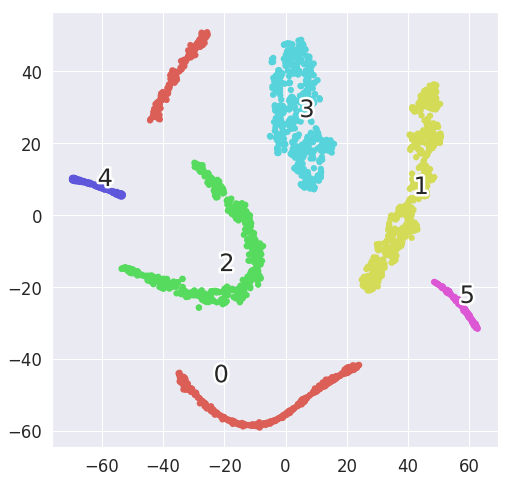

In [7]:
X=output.cpu()
y = np.array([g.label for g in graphs])
############################################################
from sklearn.manifold import TSNE
import time
time_start = time.time()

fashion_tsne = TSNE(random_state=0).fit_transform(X)
fashion_scatter(fashion_tsne, y)

In [8]:
np.unique(y)

array([0, 1, 2, 3, 4, 5])

In [9]:
import networkx as nx
from scipy import linalg
## Coming from https://github.com/mseitzer/pytorch-fid
def compute_FID(mu1, mu2, cov1, cov2, eps = 1e-6):
    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert cov1.shape == cov2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2
    # Product might be almost singular
    covmean, _ = linalg.sqrtm(cov1.dot(cov2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
                'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(cov1.shape[0]) * eps
        covmean = linalg.sqrtm((cov1 + offset).dot(cov2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(cov1) +
            np.trace(cov2) - 2 * tr_covmean)

def compute_fid(ref_graph,ref_label,pred_graph,model):
    device = 0
    num_layers = 5
    num_mlp_layers = 2
    hidden_dim = 64
    final_dropout = 0.5
    graph_pooling_type = "sum"
    neighbor_pooling_type = "sum"
    learn_eps = False
    
    #set up seeds and gpu device
    torch.manual_seed(0)
    np.random.seed(0)
    device = torch.device("cuda:" + str(device)) if torch.cuda.is_available() else torch.device("cpu")
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(0)
    #model = GraphCNN(num_layers, num_mlp_layers, train_graphs[0].node_features.shape[1], hidden_dim, 5, final_dropout, learn_eps, graph_pooling_type, neighbor_pooling_type, 'cpu').to('cpu')
    #model.load_checkpoint()
    #model.eval()


    with torch.no_grad():
        embed_graphs_ref = model.get_graph_embed_sum(ref_graph)
        embed_graphs_ref=embed_graphs_ref.cpu().detach().numpy()
        mu_ref = np.mean(embed_graphs_ref, axis = 0)
        cov_ref = np.cov(embed_graphs_ref, rowvar = False)

        embed_graphs_pred = model.get_graph_embed_sum(pred_graph)
        embed_graphs_pred=embed_graphs_pred.cpu().detach().numpy()
        mu_pred = np.mean(embed_graphs_pred, axis = 0)
        cov_pred = np.cov(embed_graphs_pred, rowvar = False)

    fid = compute_FID(mu_ref,mu_pred,cov_ref,cov_pred)
    return fid

def test_acc(model, device, train_graphs):
    model.eval()

    output = pass_data_iteratively(model, train_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in train_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc = float(correct / float(len(train_graphs)))


    print("accuracy : %f" % (acc))

    return acc

In [10]:
from util import load_graph_list
graph_grid_test=load_graph_list('saved_graphs/grid_test.p',False)
graph_grid_gen=load_graph_list('generated_graphs/grid_GRANMixtureBernoulli_DFS.p',False)
graph2= []
npr = np.random.RandomState(1)
npr.shuffle(graph_grid_test)
graph_grid_test=graph_grid_test[:100]
for k in range(10,20):
    for j in range(10,20):
        graph2.append(nx.grid_2d_graph(k,j))
graph_grid_gen_rnn=load_graph_list('generated_graphs/grid_RNN_BFS.p',False)
graph_grid_gen_mlp=load_graph_list('generated_graphs/grid_RNN_MLP_BFS.p',False)
g_list_ref,_ = load_graph_asS2Vgraph(graph_grid_test,5,random,tagset , lentagset)
g_list_pred,_ = load_graph_asS2Vgraph(graph_grid_gen,5,random, tagset , lentagset)
g_list_pred2,_ = load_graph_asS2Vgraph(graph2,5,random, tagset , lentagset)
g_list_pred_rnn,_ = load_graph_asS2Vgraph(graph_grid_gen_rnn,5,random, tagset , lentagset)
g_list_pred_mlp,_ = load_graph_asS2Vgraph(graph_grid_gen_mlp,5,random, tagset , lentagset)
print(compute_fid(g_list_ref,2,g_list_pred2,model))
print(compute_fid(g_list_ref,2,g_list_pred,model))
print(compute_fid(g_list_ref,2,g_list_pred_rnn,model))
print(compute_fid(g_list_ref,2,g_list_pred_mlp,model))
test_acc(model,'cuda:0',g_list_ref)
test_acc(model,'cuda:0',g_list_pred)
test_acc(model,'cuda:0',g_list_pred_rnn)
test_acc(model,'cuda:0',g_list_pred_mlp)

# classes: 1
# maximum node tag: 3
# data: 100
# classes: 1
# maximum node tag: 4
# data: 100
# classes: 1
# maximum node tag: 3
# data: 100
# classes: 1
# maximum node tag: 8
# data: 100
# classes: 1
# maximum node tag: 8
# data: 100
10.546660790896567
1757.1287410703262
40893.56887614438
57068.91785155856
accuracy : 1.000000
accuracy : 0.990000
accuracy : 0.620000
accuracy : 0.060000


0.06

In [11]:
graph_ba_test=load_graph_list('saved_graphs/barabasi_test.p',False)
npr = np.random.RandomState(1)
npr.shuffle(graph_ba_test)
graph_ba_test=graph_ba_test[:500]
graph_ba_gen_dd=load_graph_list('generated_graphs/barabasi_GRANMixtureBernoulli_degree_decent.p',False)
graph_ba_gen_bfs=load_graph_list('generated_graphs/barabasi_GRANMixtureBernoulli_BFS.p',False)
graph_ba_gen_dfs=load_graph_list('generated_graphs/barabasi_GRANMixtureBernoulli_DFS.p',False)
graph_ba_gen_kcore=load_graph_list('generated_graphs/barabasi_GRANMixtureBernoulli_k_core.p',False)
graph_ba_gen_noorder=load_graph_list('generated_graphs/barabasi_GRANMixtureBernoulli_no_order.p',False)
graph_ba_regen=[]
for i in range(100,200):
    for j in range(5):
        g=nx.barabasi_albert_graph(i,4)
        graph_ba_regen.append(g)
g_list_ref_ba,_ = load_graph_asS2Vgraph(graph_ba_test,2,random, tagset , lentagset)
g_list_ref_ba_regen,_ = load_graph_asS2Vgraph(graph_ba_regen,2,random, tagset , lentagset)
g_list_ref_ba_dd,_ = load_graph_asS2Vgraph(graph_ba_gen_dd,2,random, tagset , lentagset)
g_list_ref_ba_bfs,_ = load_graph_asS2Vgraph(graph_ba_gen_bfs,2,random, tagset , lentagset)
g_list_ref_ba_dfs,_ = load_graph_asS2Vgraph(graph_ba_gen_dfs,2,random, tagset , lentagset)
g_list_ref_ba_kcore,_ = load_graph_asS2Vgraph(graph_ba_gen_kcore,2,random, tagset , lentagset)
g_list_ref_ba_no,_ = load_graph_asS2Vgraph(graph_ba_gen_noorder,2,random, tagset , lentagset)
print(compute_fid(g_list_ref_ba,2,g_list_ref_ba_regen,model))
print(compute_fid(g_list_ref_ba,2,g_list_ref_ba_dd,model))
print(compute_fid(g_list_ref_ba,2,g_list_ref_ba_bfs,model))
print(compute_fid(g_list_ref_ba,2,g_list_ref_ba_dfs,model))
print(compute_fid(g_list_ref_ba,2,g_list_ref_ba_kcore,model))
print(compute_fid(g_list_ref_ba,2,g_list_ref_ba_no,model))

test_acc(model,'cuda:0',g_list_ref_ba)
test_acc(model,'cuda:0',g_list_ref_ba_dd)
test_acc(model,'cuda:0',g_list_ref_ba_bfs)
test_acc(model,'cuda:0',g_list_ref_ba_dfs)
test_acc(model,'cuda:0',g_list_ref_ba_kcore)
test_acc(model,'cuda:0',g_list_ref_ba_no)

# classes: 1
# maximum node tag: 63
# data: 500
# classes: 1
# maximum node tag: 66
# data: 500
# classes: 1
# maximum node tag: 65
# data: 500
# classes: 1
# maximum node tag: 64
# data: 500
# classes: 1
# maximum node tag: 69
# data: 500
# classes: 1
# maximum node tag: 58
# data: 500
# classes: 1
# maximum node tag: 66
# data: 500
134.70335396096925
12992.832628891818
23287.256740004377
39634.11826801114
13096.858524394556
51942.69099179399
accuracy : 1.000000
accuracy : 0.996000
accuracy : 0.998000
accuracy : 0.996000
accuracy : 0.996000
accuracy : 1.000000


1.0

In [12]:
graph_ws_test=load_graph_list('saved_graphs/watts_test.p',False)
npr = np.random.RandomState(1)
npr.shuffle(graph_ws_test)
graph_ws_test=graph_ba_test[:500]
graph_ws_gen_dd=load_graph_list('generated_graphs/wattsSW_GRANMixtureBernoulli_degree_descent.p',False)
graph_ws_gen_bfs=load_graph_list('generated_graphs/wattsSW_GRANMixtureBernoulli_BFS.p',False)
graph_ws_gen_dfs=load_graph_list('generated_graphs/wattsSW_GRANMixtureBernoulli_DFS.p',False)
graph_ws_gen_kcore=load_graph_list('generated_graphs/wattsSW_GRANMixtureBernoulli_k_core.p',False)
graph_ws_gen_noorder=load_graph_list('generated_graphs/wattsSW_GRANMixtureBernoulli_no_order.p',False)
graph_ws_regen=[]
for i in range(100,200):
    for j in range(5):
        g=nx.watts_strogatz_graph(i,4,0.1)
        graph_ws_regen.append(g)
g_list_ref_ws,_ = load_graph_asS2Vgraph(graph_ws_test,1,random, tagset , lentagset)
g_list_ref_ws_regen,_ = load_graph_asS2Vgraph(graph_ws_regen,1,random, tagset , lentagset)
g_list_ref_ws_dd,_ = load_graph_asS2Vgraph(graph_ws_gen_dd,1,random, tagset , lentagset)
g_list_ref_ws_bfs,_ = load_graph_asS2Vgraph(graph_ws_gen_bfs,1,random, tagset , lentagset)
g_list_ref_ws_dfs,_ = load_graph_asS2Vgraph(graph_ws_gen_dfs,1,random, tagset , lentagset)
g_list_ref_ws_kcore,_ = load_graph_asS2Vgraph(graph_ws_gen_kcore,1,random, tagset , lentagset)
g_list_ref_ws_no,_ = load_graph_asS2Vgraph(graph_ws_gen_noorder,1,random, tagset , lentagset)
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_regen,model))
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_dd,model))
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_bfs,model))
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_dfs,model))
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_kcore,model))
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_no,model))

test_acc(model,'cuda:0',g_list_ref_ws)
test_acc(model,'cuda:0',g_list_ref_ws_dd)
test_acc(model,'cuda:0',g_list_ref_ws_bfs)
test_acc(model,'cuda:0',g_list_ref_ws_dfs)
test_acc(model,'cuda:0',g_list_ref_ws_kcore)
test_acc(model,'cuda:0',g_list_ref_ws_no)

# classes: 1
# maximum node tag: 63
# data: 500
# classes: 1
# maximum node tag: 7
# data: 500
# classes: 1
# maximum node tag: 16
# data: 500
# classes: 1
# maximum node tag: 29
# data: 500
# classes: 1
# maximum node tag: 10
# data: 500
# classes: 1
# maximum node tag: 10
# data: 500
# classes: 1
# maximum node tag: 25
# data: 500
216058.07199987827
212858.14044479723
175237.88003746438
211410.61271011838
204524.7686193012
211789.92593212583
accuracy : 0.000000
accuracy : 0.994000
accuracy : 0.950000
accuracy : 0.990000
accuracy : 0.986000
accuracy : 1.000000


1.0

In [13]:
def n_community(c_sizes, p_inter=0.01):
    graphs = [nx.gnp_random_graph(c_sizes[i], 0.7, seed=i) for i in range(len(c_sizes))]
    G = nx.disjoint_union_all(graphs)
    communities = [G.subgraph(c) for c in nx.connected_components(G)]
    for i in range(len(communities)):
        subG1 = communities[i]
        nodes1 = list(subG1.nodes())
        for j in range(i + 1, len(communities)):
            subG2 = communities[j]
            nodes2 = list(subG2.nodes())
            has_inter_edge = False
            for n1 in nodes1:
                for n2 in nodes2:
                    if np.random.rand() < p_inter:
                        G.add_edge(n1, n2)
                        has_inter_edge = True
            if not has_inter_edge:
                G.add_edge(nodes1[0], nodes2[0])
    # print('connected comp: ', len(list(nx.connected_component_subgraphs(G))))
    return G

graph_com2_test=load_graph_list('saved_graphs/community2_test.p',False)
graph_com2_gen_dd=load_graph_list('generated_graphs/community2small_GRANMixtureBernoulli_DFS.p',False)
graph3=[]
for i in range(500):
    c_sizes = np.random.choice(list(range(12, 17)), 2)
    graph3.append(n_community(c_sizes, p_inter=0.05))
g_list_ref_com2,_ = load_graph_asS2Vgraph(graph_com2_test,3,random, tagset , lentagset)
g_list_pred_com2,_ = load_graph_asS2Vgraph(graph_com2_gen_dd,3,random, tagset , lentagset)
g_list_pred_com3,_ = load_graph_asS2Vgraph(graph3,3,random, tagset , lentagset)
print(compute_fid(g_list_ref_com2,2,g_list_pred_com2,model))
print(compute_fid(g_list_ref_com2,2,g_list_pred_com3,model))
test_acc(model,'cuda:0',g_list_ref_com2)
test_acc(model,'cuda:0',g_list_pred_com2)

# classes: 1
# maximum node tag: 15
# data: 500
# classes: 1
# maximum node tag: 17
# data: 500
# classes: 1
# maximum node tag: 15
# data: 500
45.66446075860176
1.4965780199312348
accuracy : 1.000000
accuracy : 1.000000


1.0

In [14]:
def test_acc(model, device, train_graphs):
    model.eval()

    output = pass_data_iteratively(model, train_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in train_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc = float(correct / float(len(train_graphs)))


    print("accuracy : %f" % (acc))

    return acc

def n_community(c_sizes, p_inter=0.01):
    graphs = [nx.gnp_random_graph(c_sizes[i], 0.7, seed=i) for i in range(len(c_sizes))]
    G = nx.disjoint_union_all(graphs)
    communities = [G.subgraph(c) for c in nx.connected_components(G)]
    for i in range(len(communities)):
        subG1 = communities[i]
        nodes1 = list(subG1.nodes())
        for j in range(i + 1, len(communities)):
            subG2 = communities[j]
            nodes2 = list(subG2.nodes())
            has_inter_edge = False
            for n1 in nodes1:
                for n2 in nodes2:
                    if np.random.rand() < p_inter:
                        G.add_edge(n1, n2)
                        has_inter_edge = True
            if not has_inter_edge:
                G.add_edge(nodes1[0], nodes2[0])
    # print('connected comp: ', len(list(nx.connected_component_subgraphs(G))))
    return G

test_acc(model,'cuda:0',g_list_pred_rnn)

accuracy : 0.620000


0.62